<a href="https://colab.research.google.com/github/danteaguirreb/machine_learning/blob/main/Clase6_Ensemble_Boosting_Dante.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clase 6 – Ensemble Learning, Bagging, Boosting, AdaBoost y XGBoost

Notebook de apoyo para entender la presentación de **Ensemble Learning - Boosting: AdaBoost y XGBoost**.

En este cuaderno iremos mezclando:
- Explicaciones en texto
- Ejemplos numéricos o algebraicos simples
- Código en Python
- Gráficas con `matplotlib`

Usaremos principalmente datasets sintéticos pequeños para que se vea **qué está pasando** paso a paso.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingRegressor
from sklearn.datasets import make_classification, make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

%matplotlib inline

## 1. Ensemble Learning – Idea básica

**Ensemble learning** = combinar varios modelos ("learners") para obtener un modelo final que suele tener mejor desempeño que cada modelo por separado.

Un ejemplo numérico muy simple: supongamos que tres modelos clasifican una observación como:

- Modelo 1 → clase = 1  
- Modelo 2 → clase = 0  
- Modelo 3 → clase = 1  

Si usamos **votación mayoritaria**, la predicción del ensamblaje es la clase que más se repite.

In [2]:
# Ejemplo numérico de votación mayoritaria
predicciones = np.array([1, 0, 1])  # salidas de 3 modelos débiles

valores, conteos = np.unique(predicciones, return_counts=True)
clase_final = valores[np.argmax(conteos)]

print('Predicciones individuales:', predicciones)
print('Clases únicas     :', valores)
print('Frecuencias       :', conteos)
print('Predicción ensemble (mayoría):', clase_final)

Predicciones individuales: [1 0 1]
Clases únicas     : [0 1]
Frecuencias       : [1 2]
Predicción ensemble (mayoría): 1


## 2. Bagging (Bootstrap Aggregating)

En **bagging**:
- Tomamos muchas muestras *bootstrap* del dataset (muestras con reemplazo).
- Entrenamos un modelo en cada muestra.
- Promediamos sus predicciones (regresión) o usamos voto mayoritario (clasificación).

### 2.1. Mini‑ejemplo de bootstrap numérico
Tomemos un conjunto de índices `[0,1,2,3,4]` y generemos varias muestras con reemplazo.

In [3]:
# Ejemplo numérico de bootstrapping de índices
rng = np.random.RandomState(42)
indices = np.arange(5)

print('Índices originales:', indices)
for b in range(3):
    muestra = rng.choice(indices, size=len(indices), replace=True)
    print(f'Muestra bootstrap {b+1}:', muestra)

Índices originales: [0 1 2 3 4]
Muestra bootstrap 1: [3 4 2 4 4]
Muestra bootstrap 2: [1 2 2 2 4]
Muestra bootstrap 3: [3 2 4 1 3]


### 2.2. Ejemplo gráfico de Bagging con un dataset sintético

Usaremos un dataset 2D sencillo (`make_moons`) y entrenaremos:
- Un solo árbol de decisión profundo (modelo base)
- Un **BaggingClassifier** con muchos árboles simples

Luego graficaremos la frontera de decisión de cada uno.

In [5]:
# Dataset sintético 2D
X, y = make_moons(n_samples=500, noise=0.3, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Modelo base: un solo árbol
tree = DecisionTreeClassifier(max_depth=3, random_state=0)
tree.fit(X_train, y_train)

# Bagging con árboles poco profundos
bag = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=3),
    n_estimators=50,
    bootstrap=True,
    random_state=0
)
bag.fit(X_train, y_train)

print('Accuracy árbol base (test):', accuracy_score(y_test, tree.predict(X_test)))
print('Accuracy bagging   (test):', accuracy_score(y_test, bag.predict(X_test)))

Accuracy árbol base (test): 0.88
Accuracy bagging   (test): 0.88


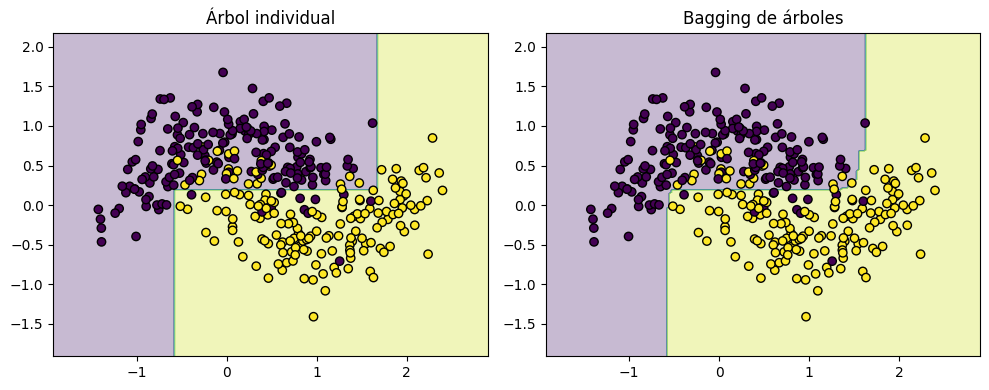

In [6]:
# Función auxiliar para graficar frontera de decisión
def plot_decision_boundary(model, X, y, ax, title):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid).reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.3)
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k')
    ax.set_title(title)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_decision_boundary(tree, X_train, y_train, axes[0], 'Árbol individual')
plot_decision_boundary(bag, X_train, y_train, axes[1], 'Bagging de árboles')
plt.tight_layout()
plt.show()

## 3. Boosting – Idea general

En **boosting** los modelos se entrenan **secuencialmente**:

1. Entrenamos un modelo débil.
2. Miramos en qué observaciones se equivoca.
3. Entrenamos el siguiente modelo poniendo **más peso** en esas observaciones difíciles.
4. Repetimos varias veces.

Al final combinamos todos los modelos ponderando según su desempeño.

Esto apunta a reducir principalmente el **sesgo** (modelos simples que se van corrigiendo entre sí).

## 4. AdaBoost

Según la presentación, el algoritmo AdaBoost (para clasificación binaria) hace lo siguiente:

1. Inicializa pesos iguales para todas las observaciones $$omega_i = 1/N $$.
2. Para cada iteración $(m = 1, \dots, M\)$$
   - Entrena un clasificador débil $$G_m(x)$$ usando los pesos $$\omega_i$$.
   - Calcula el error ponderado $${err}_m$$
   - Calcula el peso del modelo $$\(\alpha_m = \log\left(\frac{1-\text{err}_m}{\text{err}_m}\right)\)$$.
   - Aumenta los pesos de las observaciones mal clasificadas.
3. La predicción final es el signo de la suma ponderada de los clasificadores.

A continuación veremos un **mini‑ejemplo numérico** de cómo cambian los pesos.

In [7]:
# Mini‑ejemplo numérico de actualización de pesos en AdaBoost
y_true = np.array([1, 1, 1, 0, 0])  # etiquetas verdaderas (clases 0 y 1)
y_pred = np.array([1, 0, 1, 0, 1])  # predicción de un clasificador débil
N = len(y_true)

# 1) pesos iniciales
w = np.ones(N) / N

# 2) error ponderado
misclassified = (y_true != y_pred)
err = np.sum(w[misclassified]) / np.sum(w)

# 3) peso del modelo
alpha = np.log((1 - err) / err)

# 4) actualización de pesos: se multiplican por exp(alpha) si están mal clasificados
w_new = w * np.exp(alpha * misclassified.astype(float))
w_new /= w_new.sum()  # normalización

print('y_true          :', y_true)
print('y_pred          :', y_pred)
print('Pesos iniciales :', np.round(w, 3))
print('Error ponderado :', round(err, 3))
print('alpha           :', round(alpha, 3))
print('Misclasificados?:', misclassified.astype(int))
print('Pesos nuevos    :', np.round(w_new, 3))

y_true          : [1 1 1 0 0]
y_pred          : [1 0 1 0 1]
Pesos iniciales : [0.2 0.2 0.2 0.2 0.2]
Error ponderado : 0.4
alpha           : 0.405
Misclasificados?: [0 1 0 0 1]
Pesos nuevos    : [0.167 0.25  0.167 0.167 0.25 ]


Observa cómo las observaciones mal clasificadas quedan con mayor peso en `w_new`. El siguiente clasificador en la secuencia se enfocará más en ellas.

### 4.1. AdaBoost con árboles de decisión poco profundos

Ahora entrenaremos AdaBoost sobre el mismo dataset `make_moons` y compararemos contra un solo árbol.

Accuracy árbol base (test): 0.8
Accuracy AdaBoost   (test): 0.8666666666666667


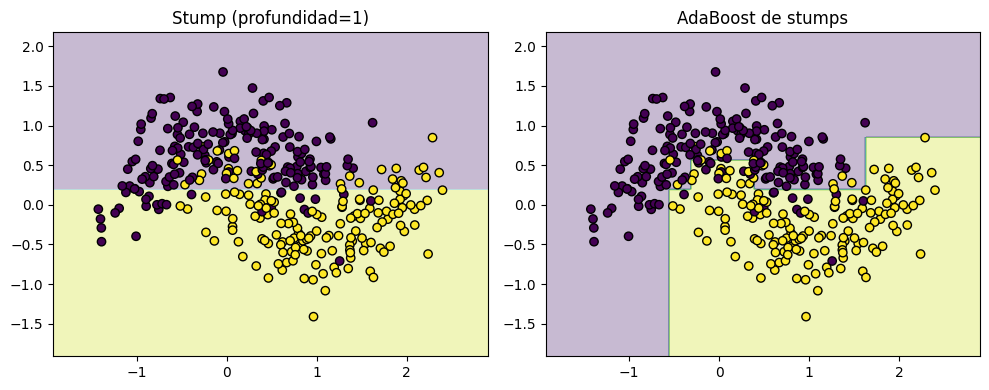

In [9]:
# AdaBoost con árboles muy simples (stumps)
stump = DecisionTreeClassifier(max_depth=1, random_state=0)
ada = AdaBoostClassifier(
    estimator=stump,
    n_estimators=50,
    learning_rate=1.0,
    random_state=0
)
ada.fit(X_train, y_train)

print('Accuracy árbol base (test):', accuracy_score(y_test, stump.fit(X_train, y_train).predict(X_test)))
print('Accuracy AdaBoost   (test):', accuracy_score(y_test, ada.predict(X_test)))

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_decision_boundary(stump, X_train, y_train, axes[0], 'Stump (profundidad=1)')
plot_decision_boundary(ada, X_train, y_train, axes[1], 'AdaBoost de stumps')
plt.tight_layout()
plt.show()

## 5. Gradient Boosting – intuición con regresión 1D

En **Gradient Boosting** también entrenamos modelos secuencialmente, pero lo miramos como un problema de **optimización**:

- Definimos una **función de pérdida** $$L(\theta)$$, por ejemplo el error cuadrático medio.
- En cada iteración añadimos un nuevo árbol que intenta **corregir los residuos** del modelo anterior (el gradiente negativo de la pérdida).

Vamos a verlo con un ejemplo de regresión en 1D.

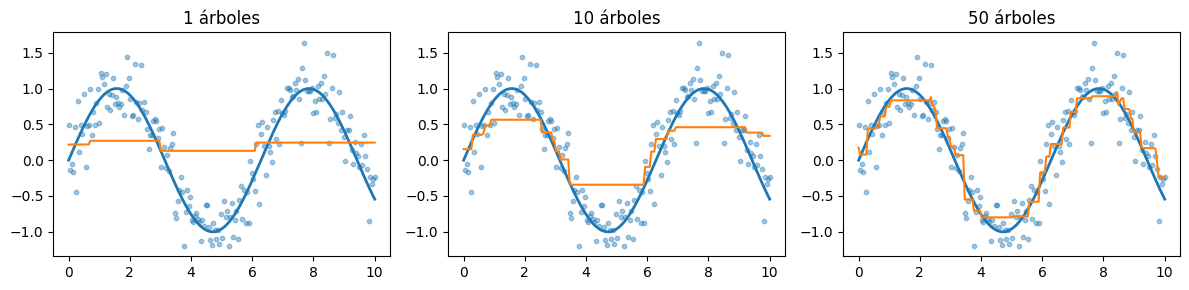

In [10]:
# Dataset de regresión 1D
rng = np.random.RandomState(1)
X_reg = np.linspace(0, 10, 200).reshape(-1, 1)
y_true_reg = np.sin(X_reg).ravel()
y_reg = y_true_reg + rng.normal(scale=0.3, size=y_true_reg.shape)

# Entrenamos un GradientBoostingRegressor
gbr = GradientBoostingRegressor(
    n_estimators=50,
    max_depth=2,
    learning_rate=0.1,
    random_state=0
)
gbr.fit(X_reg, y_reg)

# Predicciones progresivas para ver cómo se construye el ensemble
stage_preds = list(gbr.staged_predict(X_reg))

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
for ax, step in zip(axes, [1, 10, 50]):
    ax.scatter(X_reg, y_reg, s=10, alpha=0.4)
    ax.plot(X_reg, y_true_reg, linewidth=2)
    ax.plot(X_reg, stage_preds[step-1])
    ax.set_title(f'{step} árboles')
plt.tight_layout()
plt.show()

En la figura se ve cómo el modelo parte muy simple (1 árbol) y, al agregar más árboles, va ajustándose mejor a la forma senoidal, reduciendo los residuos.

## 6. Regularización y función de pérdida

En la presentación se muestra la función objetivo típica de XGBoost:

$$\text{obj}(\theta) = L(\theta) + \Omega(\theta) $$

-$$L(\theta)\$$: pérdida de entrenamiento (por ejemplo MSE o devianza).

-$$\Omega(\theta)\$$: término de **regularización** que penaliza la complejidad de los árboles.

Veamos un ejemplo ultra simple con regresión lineal donde sumamos un término de regularización L2.
Solo haremos el cálculo numérico de la pérdida para distintos valores de un parámetro.

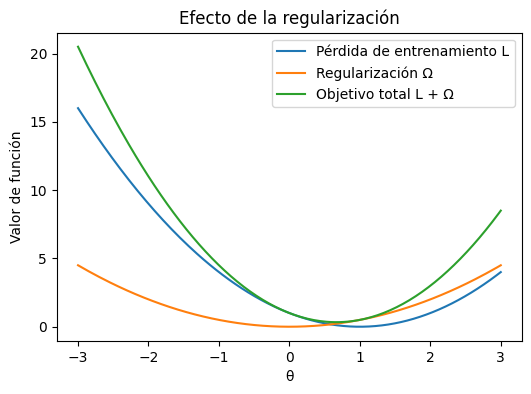

In [14]:
# Ejemplo simple de pérdida con regularización L2
theta_vals = np.linspace(-3, 3, 200)

# Pérdida de entrenamiento artificial: mínimo en theta = 1
L = (theta_vals - 1)**2

# Regularización L2: penaliza valores grandes de theta
lambda_reg = 0.5
Omega = lambda_reg * theta_vals**2

obj = L + Omega

plt.figure(figsize=(6,4))
plt.plot(theta_vals, L, label='Pérdida de entrenamiento L')
plt.plot(theta_vals, Omega, label='Regularización Ω')
plt.plot(theta_vals, obj, label='Objetivo total L + Ω')
plt.legend()
plt.xlabel('θ')
plt.ylabel('Valor de función')
plt.title('Efecto de la regularización')
plt.show()

Observa cómo el mínimo de la función objetivo total `L + Ω` se mueve un poco hacia $$\theta = 0$$ debido a la regularización, encogiendo el parámetro y evitando soluciones demasiado extremas.

## 7. Comparación rápida: árbol vs Bagging vs AdaBoost vs Gradient Boosting

Para cerrar, comparamos la precisión de distintos modelos sobre el mismo dataset `make_classification`.

In [13]:
# Dataset de clasificación
Xc, yc = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=5,
    n_redundant=0,
    random_state=0
)
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, test_size=0.3, random_state=0)

# Modelos
tree2 = DecisionTreeClassifier(max_depth=None, random_state=0)
bag2 = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=None),
    n_estimators=50,
    random_state=0
)
ada2 = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=50,
    learning_rate=1.0, # Added learning_rate for AdaBoostClassifier
    random_state=0
)

# Para clasificación usaremos GradientBoostingClassifier approximado con GradientBoostingRegressor
# simplificando: entrenamos un regresor sobre etiquetas 0/1 y luego redondeamos.
gbr_cls = GradientBoostingRegressor(
    n_estimators=50,
    max_depth=3,
    learning_rate=0.1,
    random_state=0
)

# Entrenamiento
tree2.fit(Xc_train, yc_train)
bag2.fit(Xc_train, yc_train)
ada2.fit(Xc_train, yc_train)
gbr_cls.fit(Xc_train, yc_train)

# Predicciones
pred_tree = tree2.predict(Xc_test)
pred_bag = bag2.predict(Xc_test)
pred_ada = ada2.predict(Xc_test)
pred_gbr = (gbr_cls.predict(Xc_test) > 0.5).astype(int)

print('Accuracy árbol           :', accuracy_score(yc_test, pred_tree))
print('Accuracy bagging         :', accuracy_score(yc_test, pred_bag))
print('Accuracy AdaBoost        :', accuracy_score(yc_test, pred_ada))
print('Accuracy GradientBoosting:', accuracy_score(yc_test, pred_gbr))

Accuracy árbol           : 0.8666666666666667
Accuracy bagging         : 0.9266666666666666
Accuracy AdaBoost        : 0.9066666666666666
Accuracy GradientBoosting: 0.93


En general, los métodos de ensamblaje bien configurados tienden a superar a un único árbol, porque reducen varianza (bagging) o sesgo (boosting), o ambos en cierta medida.

## 8. Cierre

En este notebook vimos de forma práctica los conceptos de la clase:

- Ensemble learning y votación mayoritaria.
- Bagging y bootstrapping.
- Boosting y el foco en observaciones difíciles.
- AdaBoost con actualización de pesos y ejemplo gráfico.
- Gradient Boosting visto como minimización de residuos.
- Regularización en la función objetivo.
- Comparación rápida de desempeño entre modelos.

Puedes ir ejecutando celda por celda mientras escuchas la clase para ir conectando teoría con práctica.